In [1]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [2]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L_arr = [16]
J_arr = [1]
h_arr = [0.05]
lamb_arr = [0.7]
g_arr = [None, 8]

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = 50000

odr = True
flip_threshold = 4

redo_simulations = False

execution_database = "z2_chain_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

# Load hardware results

In [3]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits, odr_compuncomp_circuits
from z2chain.operators import local_pauli_z, local_pauli_x, postselection_operators
from cobos.tokens import ibm_token, group_instance, group_instance2
from utils.postselection import load_postselected_jobs
from utils.hexec import get_backend_best_qubit_chain
from qiskit_ibm_runtime import QiskitRuntimeService
from utils.circs import generate_and_save_circs
from functools import partial
from itertools import product
import os
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_brisbane"
device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

eplg_absolute = 9.08e-3

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

optimization_level = 2

hardware_circuits = [] # hardware_circuits[L][params][t]
if odr: odr_circuits = [] # odr_circuits[L][params][t]
hardware_observable_generating_funcs = [] #hardware_observable_generating_funcs[L][i]
hardware_postselection_operators_funcs = []
extra_options = []

sampler_options = {
    "default_shots": shots,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": shots//100,
        "shots_per_randomization": 100
    }
}

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
    this_circuits = []
    if odr: this_odr_circuits = []
    this_extra_options = []
    for J, h, lamb, g in product(J_arr, h_arr, lamb_arr, g_arr):
        circuits_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
        circs_func_args = (L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
        physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis=x_basis, force_even=True)
        this_circuits.append(physical_circuits)
        this_extra_options.append({"backend": device, "L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": pp_ps, "particle_pair_length": particle_pair_length, "final_time": final_time, "eplg": eplg_absolute})
        if odr:
            odr_func_args = (L, J, h, lamb, final_time, steps, backend, eplg_absolute, g, pp_ps, particle_pair_length, qubits_inds, x_basis)
            this_odr_circuits.append(odr_compuncomp_circuits(*odr_func_args))
    hardware_circuits.append(this_circuits)
    if odr: odr_circuits.append(this_odr_circuits)
    hardware_observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    hardware_postselection_operators_funcs.append(lambda nqubits: postselection_operators((nqubits + 1)//2, x_basis))
    extra_options.append(this_extra_options)

hardware_odr_observables = [] #hardware[L][opts][i]
hardware_odr_samples_dicts = [] #hardware_samples_dicts[L][opts][i][real/cal]
hardware_odr_postselected_samples_dicts = [] #hardware_postselected_samples_dicts[L][opts][i][real/cal]

for i, L in enumerate(L_arr):
    this_L_observables = []
    this_L_samples_dicts = []
    this_L_postselected_samples_dicts = []  
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        clean_extra_options = extra_options[i][j].copy()
        del clean_extra_options["eplg"]
        if odr:
            this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, clean_extra_options, hardware_circuits[i][j], hardware_postselection_operators_funcs[i], hardware_observable_generating_funcs[i], clean_extra_options, flip_threshold=flip_threshold, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True, odr_circuits=odr_circuits[i][j]) 
        else:
            this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, clean_extra_options, hardware_circuits[i][j], hardware_postselection_operators_funcs[i], hardware_observable_generating_funcs[i], clean_extra_options, flip_threshold=flip_threshold, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True)
        this_L_observables.append(this_observables)
        this_L_samples_dicts.append(this_samples_dicts[1])
        this_L_postselected_samples_dicts.append(this_postselected_samples_dicts[1])
    hardware_odr_observables.append(this_L_observables)
    hardware_odr_samples_dicts.append(this_L_samples_dicts)
    hardware_odr_postselected_samples_dicts.append(this_L_postselected_samples_dicts)

# Simulate results

In [4]:
# from z2chain.circs import erradj_particle_pair_quench_simulation_circuits
# from z2chain.operators import local_pauli_x, local_pauli_z
# from utils.circs import generate_and_save_circs
# from qiskit_aer import AerSimulator
# from itertools import product
# from functools import partial
# import numpy as np
# import os

# optimization_level = 2

# sim_circuits = [] # sim_circuits[L][Jhλg][t]

# estimator_options = {
#     "default_precision": 1e-5
# }

# simulator_options = {
#     "method": "matrix_product_state",
#     "matrix_product_state_max_bond_dimension": 256,
#     "matrix_product_state_truncation_threshold": 1e-10
# }

# backend = AerSimulator(**simulator_options)

# eplg_absolute = 2e-3

# for L, pp_ps in zip(L_arr, particle_pair_left_positions):
#     this_circuits = []
#     for J, h, lamb, g in product(J_arr, h_arr, lamb_arr, g_arr):
#         circuit_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_simulation_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
#         qubits_inds = np.arange(2*L-1).tolist()
#         circs_func_args = (L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
#         circuit = generate_and_save_circs(circuit_filepath, erradj_particle_pair_quench_simulation_circuits, *circs_func_args)
#         this_circuits.append(circuit)
#     sim_circuits.append(this_circuits)

# from utils.plotting import load_site_gauge_observable_matrix, save_site_gauge_observable_matrix, convert_jobs_to_site_gauge_matrix
# from utils.sexec import execute_simulation_estimator_batch
# from utils.circs import remove_idle_qwires

# sim_observables = [] # sim_observables[L][opts][i]

# for i, L in enumerate(L_arr):
#     this_L_observables = []
#     observables_operator_funcs = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=k) for k in range(2*L-1)]
#     for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
#         filepath = f"Results/tncirc_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.txt"
#         if os.path.exists(filepath) and not redo_simulations:
#             this_observables = load_site_gauge_observable_matrix(filepath)
#         else:
#             no_idle_circuits = [remove_idle_qwires(circuit, relabeling=np.arange(2*L-1)) for circuit in sim_circuits[i][j]]
#             this_jobs = execute_simulation_estimator_batch(simulator_options, estimator_options, no_idle_circuits, observables_operator_funcs)
#             this_observables = convert_jobs_to_site_gauge_matrix(this_jobs)
#         this_L_observables.append(this_observables)
#     sim_observables.append(this_L_observables)

# Plots

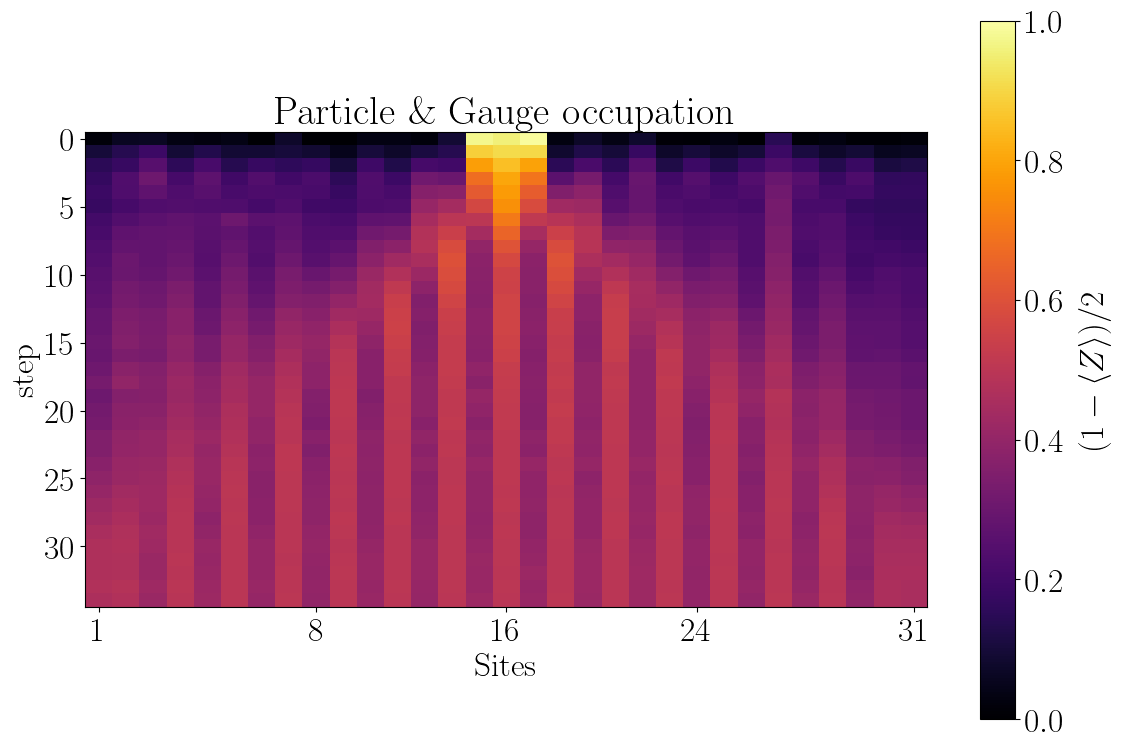

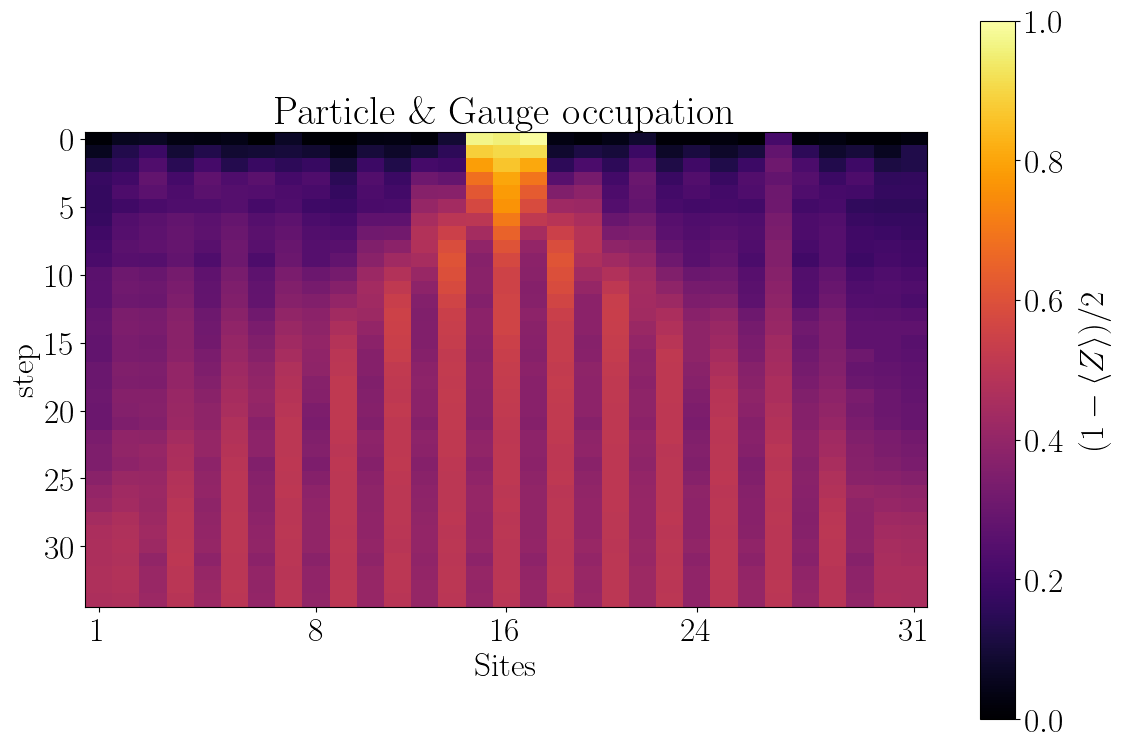

In [5]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        x_t_plot((1 - hardware_odr_observables[i][j][3])/2)

In [10]:
from utils.postselection import measure_diagonal_observables
from utils.circs import depth2qb
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def postselection_odr_dephasing_decay_plot(odr_postselected_samples_dicts, odr_samples_dicts, odr_circuits, observable_generating_funcs, observable_labels=None, colors=None, regression=True, resolution=100, filepath=""):
    plt.rc("text", usetex=True)
    plt.rc("font", size=24, family="serif", weight="bold")

    if len(odr_postselected_samples_dicts) != len(odr_samples_dicts) != len(odr_circuits):
        raise ValueError("odr_postselected_samples_dicts, odr_samples_dicts and odr_circuits must have the same length")
    else:
        nexperiments = len(odr_circuits)

    if observable_labels is not None:
        if len(observable_labels) != len(observable_generating_funcs):
            raise ValueError("observable_labels is not the same length as observable_generating_funcs")
    else:
        observable_labels = [rf"$\langle O_{i} \rangle$" for i in range(len(observable_generating_funcs))]

    circs_layouts = [circ.layout.final_index_layout() for circ in odr_circuits]
    circs_depth2qb = [depth2qb(circ) for circ in odr_circuits]
    observable_operators = [observable_func(len(circs_layouts[0])) for observable_func in observable_generating_funcs]
    postselected_observables = np.zeros((nexperiments, len(observable_operators)))
    raw_observables = np.zeros((nexperiments, len(observable_operators)))
    for i, (psamples_dict, samples_dict) in enumerate(zip(odr_postselected_samples_dicts, odr_samples_dicts)):
        postselected_observables[i, :] = measure_diagonal_observables(psamples_dict, observable_operators, circs_layouts[i])
        raw_observables[i, :] = measure_diagonal_observables(samples_dict, observable_operators, circs_layouts[i])
    
    fig, ax = plt.subplots(figsize=[9, 6])
    reg_func = lambda x, a: np.exp(-a*x)
    cmap = plt.get_cmap("Set2")
    x_regression = np.linspace(circs_depth2qb[0], circs_depth2qb[-1], resolution)
    for i, observable_operators in enumerate(observable_operators):
        if colors is None:
            color = color = cmap((i % 8)/8 + 0.01)
        else:
            color = colors[i]
        color_darker = tuple(0.6*c if i < 3 else c for i, c in enumerate(color))
        if regression:
            popt_postselected, _ = sp.optimize.curve_fit(reg_func, circs_depth2qb, postselected_observables[:, i], p0=[1])
            popt_raw, _ = sp.optimize.curve_fit(reg_func, circs_depth2qb, raw_observables[:, i])
            plt.plot(x_regression, reg_func(x_regression, *popt_postselected), "--", linestyle="dashed", color=color, label=f"$a={popt_postselected[0]:.03f}$\n")#+f"$b = {popt_postselected[1]:0.2f}$")
            plt.plot(x_regression, reg_func(x_regression, *popt_raw), "--", linestyle="dashdot", color=color, label=f"$a={popt_raw[0]:.03f}$\n")#+f"$b = {popt_raw[1]:0.2f}$")
        plt.plot(circs_depth2qb, postselected_observables[:, i], "o", markersize=10, markeredgecolor="black", color=color, label=r"$\langle %s \rangle_{\mathrm{Post}}$" % observable_labels[i], zorder=5)
        plt.plot(circs_depth2qb, raw_observables[:, i], "^", markersize=9, color=color_darker, markeredgecolor="black", label=r"$\langle %s \rangle_{\mathrm{Raw}}$" % observable_labels[i], zorder=3)
    plt.xlabel("2Qb depth")
    plt.ylim([-0.05, 1.05])
    plt.legend(prop={"size": 18})
    plt.grid(color="gray", linestyle="dashdot", linewidth=1.6, zorder=0)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=300, facecolor="none")
    plt.show()
    plt.rcdefaults()

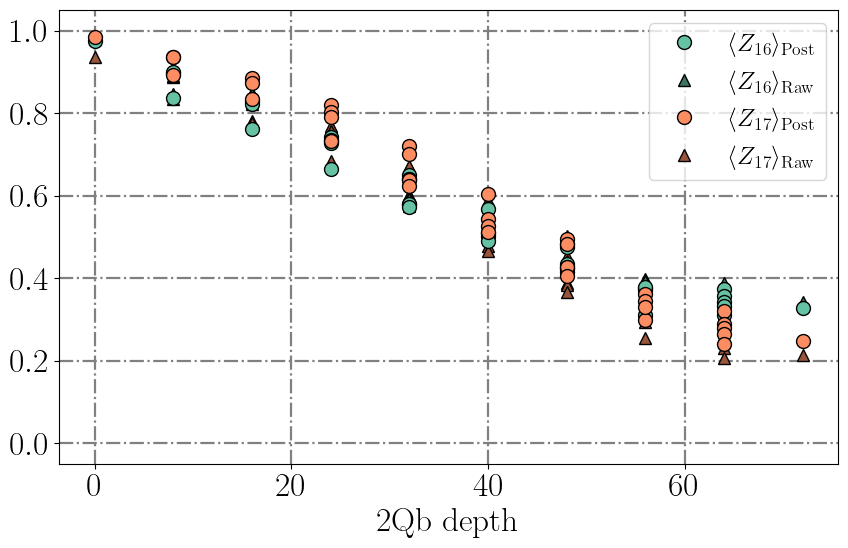

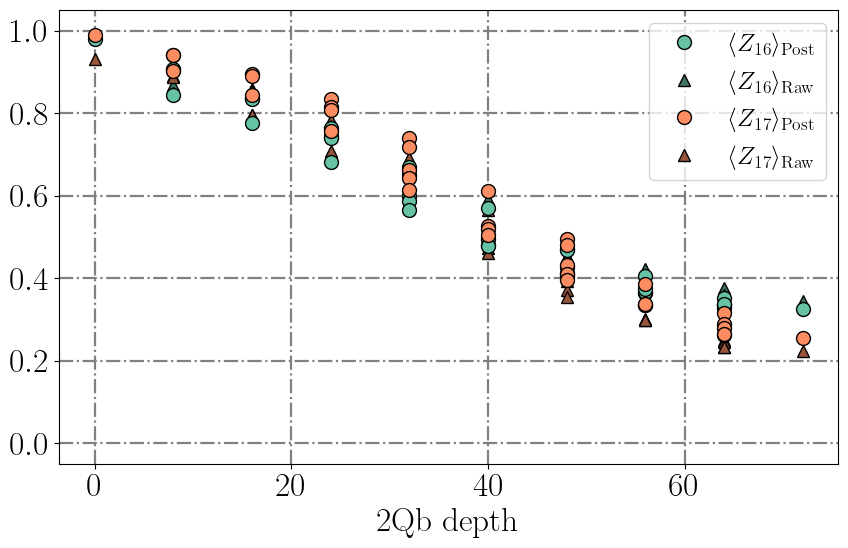

In [11]:
qubit_indices_plot = [16, 17]
plot_observable_generating_func = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=qbind) for qbind in qubit_indices_plot]
observable_labels = [r"Z_{%d}" % qbind for qbind in qubit_indices_plot]

for i, L in enumerate(L_arr):
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        postselection_odr_dephasing_decay_plot(hardware_odr_postselected_samples_dicts[i][j], hardware_odr_samples_dicts[i][j], odr_circuits[i][j], plot_observable_generating_func, observable_labels, regression=False, filepath=f"Z_odr_uniform_ft_postselection_effect_{"-".join([str(qb) for qb in qubit_indices_plot])}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")

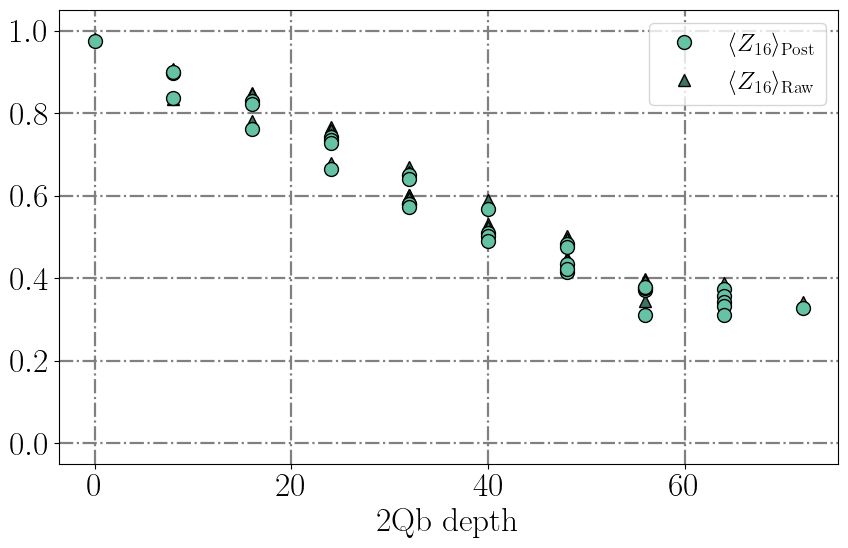

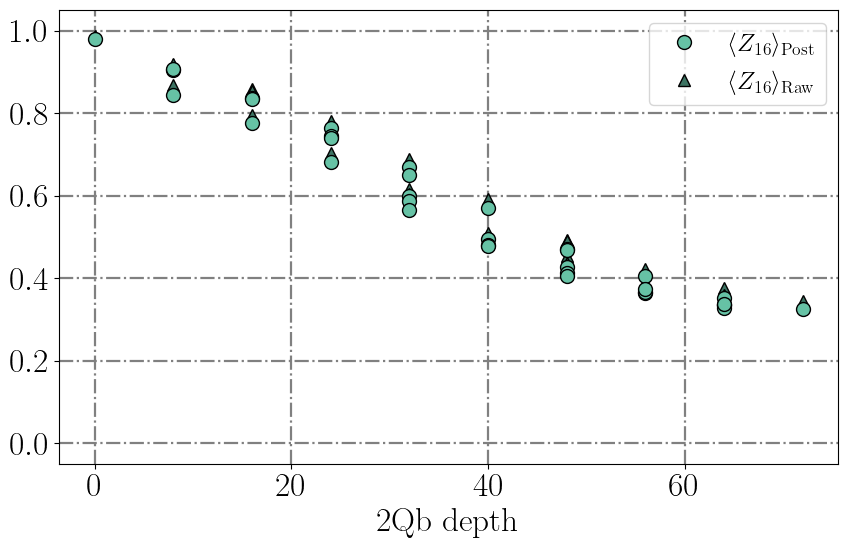

In [12]:
qubit_indices_plot = [16]
plot_observable_generating_func = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=qbind) for qbind in qubit_indices_plot]
observable_labels = [r"Z_{%d}" % qbind for qbind in qubit_indices_plot]

for i, L in enumerate(L_arr):
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        postselection_odr_dephasing_decay_plot(hardware_odr_postselected_samples_dicts[i][j], hardware_odr_samples_dicts[i][j], odr_circuits[i][j], plot_observable_generating_func, observable_labels, regression=False, filepath=f"Z_odr_uniform_ft_postselection_effect_{"-".join([str(qb) for qb in qubit_indices_plot])}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")

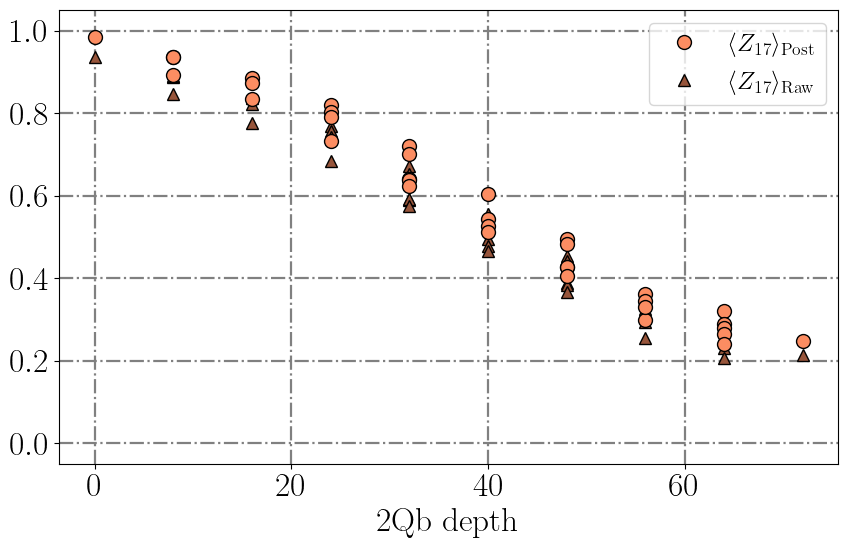

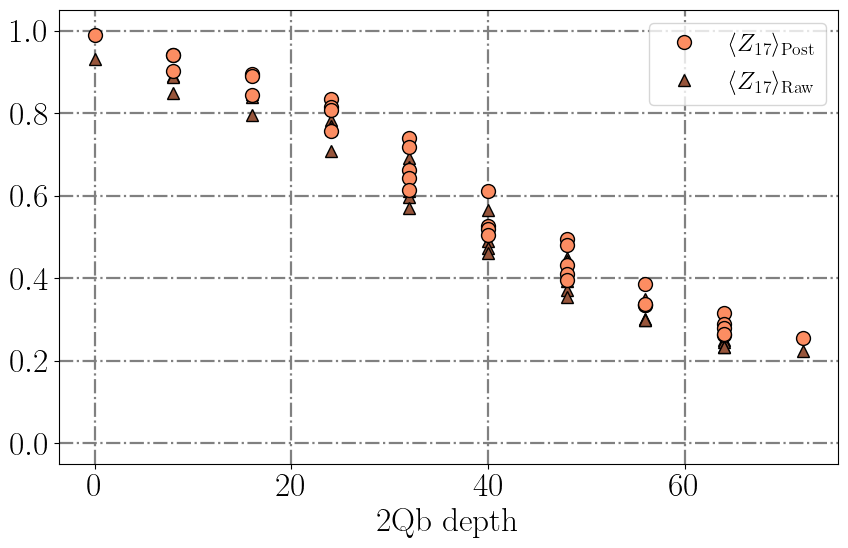

In [13]:
qubit_indices_plot = [17]
plot_observable_generating_func = [partial(local_pauli_x if x_basis else local_pauli_z, qubit_ind=qbind) for qbind in qubit_indices_plot]
observable_labels = [r"Z_{%d}" % qbind for qbind in qubit_indices_plot]

colors = [plt.get_cmap("Set2")((1 % 8)/8 + 0.01)]

for i, L in enumerate(L_arr):
    for j, (J, h, lamb, g) in enumerate(product(J_arr, h_arr, lamb_arr, g_arr)):
        postselection_odr_dephasing_decay_plot(hardware_odr_postselected_samples_dicts[i][j], hardware_odr_samples_dicts[i][j], odr_circuits[i][j], plot_observable_generating_func, observable_labels, colors=colors, regression=False, filepath=f"Z_odr_uniform_ft_postselection_effect_{"-".join([str(qb) for qb in qubit_indices_plot])}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")